# TSP + QAOA - naive approach

We need to run this line to have a proper [bra-ket](https://en.wikipedia.org/wiki/Bra–ket_notation) formatting in markdown.
$$
\newcommand{\ket}[1]{\left| #1 \right\rangle}
\newcommand{\bra}[1]{\left\langle #1 \right|}
$$

In the previous tutorials we learned what is the Traveling Salesman Problem and how to use QAOA to solve optimization problems.
<br>
Now it's finally time to solve TSP using quantum computing!

In this tutorial you will learn the following:

- How to encode TSP for QAOA
- How to solve constrained optimization problems using QAOA

I realize that it might be hard to grasp all the concepts here if you are new to the field. It sometimes gets pretty low-level and mathematical. But that's not because it's inherently difficult, rather:
- we (or I at least) have not yet discovered how to explain it in the most efficient way
- the QAOA was invented in 2014 - it's pretty new stuff. 

So don't get discouraged, asked others for help if you something seems too complicated or just get some rest and come back with a fresh mind. And remember - you're pioneer!

## Encoding the problem

One of the important decisions we need to make with any problem we encounter is how to encode our input and output data. What will be the good choice depends on many factors:
- what algorithm we use?
- do we have any constraints (e.g. amount of data, memory)?
- what hardware do we use?
- many others

One of the most convenient way of encoding solution to TSP is the one we used in the first part:

0 -> 1 -> 2 -> 3 , which for Python translates into `[0,1,2,3]` or `(0,1,2,3)`.

This means that we start from the city 0, then go to 1 and so on.

However, in case of quantum computers, one of the main constraints is that we need to use binary representation. Qubits can take only 0 or 1 values during the measurement, so this format won't work.

We know that at any given time we can be only in one city. Hence, for N cities we have N time slots.
<br>
Using binary representation, we could use N strings (representing time slots) of N bits (representing cities), where the active bit in each string is the city that we visit.

So in the case of [0,1,2,3] we will get the following matrix (row represents time slots, columns - cities):

$\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}$

Which translates into the following string of bits:

`[1,0,0,0, 0,1,0,0, 0,0,1,0, 0,0,0,1]`


This is a little bit unwieldy, so we will use the following helper methods:

In [2]:
import numpy as np
%matplotlib inline


def points_order_to_binary_state(points_order):
    """
    Transforms the order of points from the standard representation: [0, 1, 2],
    to the binary one: [1,0,0,0,1,0,0,0,1]
    """
    number_of_points = len(points_order)
    binary_state = np.zeros((len(points_order))**2)
    for j in range(len(points_order)):
        p = points_order[j]
        binary_state[(number_of_points) * (j) + (p)] = 1
    return binary_state

def binary_state_to_points_order(binary_state):
    """
    Transforms the the order of points from the binary representation: [1,0,0,0,1,0,0,0,1],
    to the binary one: [0, 1, 2]
    """
    points_order = []
    number_of_points = int(np.sqrt(len(binary_state)))
    for p in range(number_of_points):
        for j in range(number_of_points):
            if binary_state[(number_of_points) * p + j] == 1:
                points_order.append(j)
    return points_order

print(binary_state_to_points_order([1,0,0,0,1,1,0,0,1]))

[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]


Let's see if it works on an example:

In [2]:
points_order = [0, 1, 2]
binary_state = points_order_to_binary_state(points_order)
points_order_again = binary_state_to_points_order(binary_state)

print("Binary representation of ", points_order, "is", binary_state)
print(points_order_again, "should be equal to", points_order)

Binary representation of  [0, 1, 2] is [1. 0. 0. 0. 1. 0. 0. 0. 1.]
[0, 1, 2] should be equal to [0, 1, 2]


## Solving TSP

Now that we know how to encode our problem, we will use `ForestTSPSolverNaive` class to solve it. We will start with 3 cities since the calcultions are faster this way. We will go to more cities when we are sure that our code is working properly.

In [3]:
from scripts.forest_tsp_solver_naive import ForestTSPSolverNaive

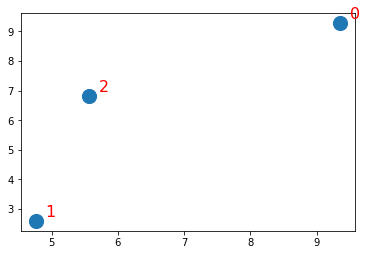

In [4]:
from scripts import utilities
from scripts import plots
import numpy as np
import matplotlib.pyplot as plt

cities = utilities.create_cities(3)
distance_matrix = utilities.get_distance_matrix(cities)
plots.plot_cities(cities)
plt.show()

In [5]:
tsp_solver = ForestTSPSolverNaive(distance_matrix, use_constraints=True)
solution, naive_distribution = tsp_solver.solve_tsp()
print("The solution is:", solution)

                     models will be ineffective
The solution is: [0, 1, 0, 1, 2, 2]


Wait a minute... This doesn't make sense at all. We wanted to get `[0, 1, 2]`, and I got `[0, 1, 2, 2]`. 
(Since the result is probabilistic, you might have gotten something different. Also every time I update this notebook I get something different, so sorry for some inconsistencies here.)
<br>
Maybe something is wrong with the `binary_state_to_points_order` in our solver? We should investigate the binary string.

In [6]:
print("Your binary solution is:", tsp_solver.most_frequent_string)
print("My initial binary solution is:", (1,1,1,0,0,0,0,0,1))

Your binary solution is: (1, 1, 0, 1, 1, 1, 0, 0, 1)
My initial binary solution is: (1, 1, 1, 0, 0, 0, 0, 0, 1)


This solution doesn't make sense at all! This string means, that at t=0 we are in all the cities at the same time, then at t=1 we are not present anywhere and at t=2 we are in the city 2.
<br>
It's not a surprise, that our order of traveling looks weird.

At this point you may have noticed something suspicious with our class. It's called `ForestTSPSolverNaive`.
<br>
"Naive"... It doesn't sound very promising to me. Let's see why I named it naive, what's actually inside it and why we got such a crappy solution.

## Creating cost operators

As you remember from the previous part, in order to make QAOA solve the problem we want, we need to translate it into its native language - language of Pauli operators.
<br>
What we need to do for the TSP is pretty similar to what we have done for MaxCut, so let's code it.

In [7]:
distance_matrix = utilities.get_distance_matrix(cities)
print(distance_matrix)
number_of_cities = len(cities)

[[0.         8.11055435 4.52981719]
 [8.11055435 0.         4.28747371]
 [4.52981719 4.28747371 0.        ]]


The last time we learned two useful equations for MaxCut which will guide us now. 
<br>
One for the classical cost function:
<br>
$C_{total} = \sum C_{ij} = \sum \frac{1}{2} w_{ij} (1 - z_i z_j) $,

And one showing how to construct the quantum cost operator:
<br>
$H_{cost} = \sum \frac{1}{2} w_{ij} (\mathbb{1} - \sigma^z_i \sigma^z_j$)

However, for TSP it's a little bit more complicated, since $i$ and $j$ correspond to indices of qubits, not the indices of cities.
<br>
I tried to write a nice mathematical formula for you, but after several minutes I have not produced anything concise and elegant.
I guess that I'm so spoiled with the programming that it's much more intuitive for me to just show you how it works in code ;)


In [8]:
from pyquil.paulis import PauliTerm

cost_operators = []
number_of_cities = len(distance_matrix)

for i in range(number_of_cities):
    for j in range(i, number_of_cities):
        for t in range(number_of_cities - 1):
            weight = -distance_matrix[i][j]/2
            if distance_matrix[i][j] != 0:
                qubit_1 = t * number_of_cities + i
                qubit_2 = (t + 1) * number_of_cities + j
                cost_operators.append(PauliTerm("I", 0, weight) - PauliTerm("Z", qubit_1, weight) * PauliTerm("Z", qubit_2))
                print("City", i, "to", j, "at t =", t, "costs", weight, "Qubits:", qubit_1, qubit_2)

City 0 to 1 at t = 0 costs -4.0552771725877745 Qubits: 0 4
City 0 to 1 at t = 1 costs -4.0552771725877745 Qubits: 3 7
City 0 to 2 at t = 0 costs -2.264908593146154 Qubits: 0 5
City 0 to 2 at t = 1 costs -2.264908593146154 Qubits: 3 8
City 1 to 2 at t = 0 costs -2.1437368574782827 Qubits: 1 5
City 1 to 2 at t = 1 costs -2.1437368574782827 Qubits: 4 8


There are several things going on here:
1. We have "-" sign before Z terms - that's because we want to get the shortest, not the longest path.
2. In principle we could omit the $\frac{1}{2}$ term. Since constants don't influence the optimization process, we can do that, though it's good to be consistent with the equations, to avoid confusion, so we finally included it.
3. We need to include every cost (N-1) times - once for each step between the cities. 3 time slots -> 2 steps.
4. It's hard to see right away why we use these qubits and not the others. Take your time to understand where are those two lines defining `qubit_1` and `qubit_2` coming from. Pen and paper is useful for that :)
5. We ommited terms with zeros - well, it didn't cost us anything ;)

And this is how the cost operators look like. As you can see, the `Z` terms correspond to the qubit indices above.

In [9]:
for single_cost_operator in cost_operators:
    print(single_cost_operator)

(-4.0552771725877745+0j)*I + (4.0552771725877745-0j)*Z0*Z4
(-4.0552771725877745+0j)*I + (4.0552771725877745-0j)*Z3*Z7
(-2.264908593146154+0j)*I + (2.264908593146154-0j)*Z0*Z5
(-2.264908593146154+0j)*I + (2.264908593146154-0j)*Z3*Z8
(-2.1437368574782827+0j)*I + (2.1437368574782827-0j)*Z1*Z5
(-2.1437368574782827+0j)*I + (2.1437368574782827-0j)*Z4*Z8


Ok, so this is basically the code we used (you can check out `forest_tsp_solver_naive.py` in `scripts` directory). 
But it doesn't answer the question, why the results we got don't make sense at all.

Take your time to solve this puzzle by yourself and when you are ready, go to the next section

I leave some blank space, so you can try to solve this mystery by yourself, without the next header spoiling it.
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

## Spoiler-free header (just in case)

One of the main reasons why it didn't work is that we forgot about the constraints.
<br>
Constraints in TSP are pretty important and there are two of them:
- we need to visit each city once
- in every moment we need to be in exactly one city

It wasn't immediately obvious to me how to encode that into our problem, so I used a standard optimization approach - adding a penalty.

### What is a penalty?

Let's say we want to find the minimum of function $x^2$, but we want only values higher than 2.

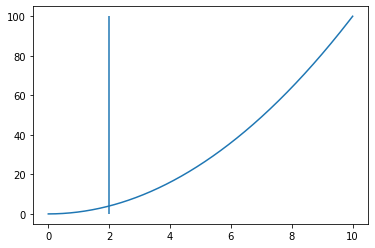

In [10]:
x = np.linspace(0, 10, 1000)
y = x**2
plt.plot(x,y)
plt.vlines(2, 0, 100)
plt.show()

It's hard to do that using some simple classical optimization methods which work only for unconstrained problems. However, we can artificially add a penalty, for values lower than 2 or higher than 8:

In [11]:
penalty = np.piecewise(x, [x<2, x>=2], [lambda x: 100*(-x+2)**3, 0])

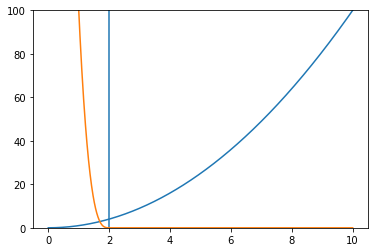

In [12]:
plt.plot(x,y)
plt.plot(x,penalty)
plt.vlines(2, 0, 100)
plt.ylim([0,100])
plt.show()

So now we solve for a slightly modified function, which has additional cost for values lower than 2:

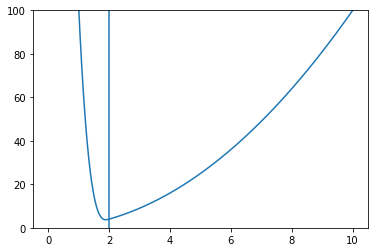

In [13]:
plt.plot(x,y + penalty)
plt.vlines(2, 0, 100)
plt.ylim([0,100])
plt.show()

This function has minimum at roughly:

In [14]:
x[np.argmin(y+penalty)]

1.8918918918918919

It's not ideal, but:
- 1.89 is a better answer than 0.
- you can make it work much better by choosing a different penalty function.
- if you consider only the integers, the minimum is actually at 2.

You can read more about this approach here: https://www.rose-hulman.edu/~bryan/lottamath/penalty.pdf

Going back to our case we have some constraints and we want to create a penalty function which will increase cost function for all the solution which don't satisfy the constraints. 

### Matrix representation of gates

At this point, we will find the matrix representation of Pauli operators quite useful, so let's see how they work before we go deep into encoding the constraints.
<br>

So far, we used the `Z` operators for assigning costs. Take a look at the following code from the MaxCut example.
```
for i, j in graph.edges():
    cost_operators.append(PauliTerm("Z", i, 0.5)*PauliTerm("Z", j) + PauliTerm("I", 0, -0.5))
```

What we wanted to achieve? We wanted to mimic the classical version of adding +1 if it's inside our solution or adding -1 if it's not.
<br>
So in order to do that we need to find the combination of pauli operators, which will add +1 for the correct solutions and add -1 for the incorrect ones. +1/-1 values will be of course parametrized.
<br>
It will be helpful to see how the matrix representation of Pauli operators looks like.

A single 'Z' matrix is given by the following matrix:
<br>
$Z_1 = \begin{bmatrix}
1 & 0 \\
0 & -1 \\
\end{bmatrix}$
<br>

First column/row represents $\ket{0}$ and the second one $\ket{1}$.
So if we apply $Z_1$ to given quantum state, it will change $\ket{0}$ into $\ket{0}$ (so no change) and $\ket{1}$ into $-\ket{1}$.

When we do an operation $Z_1 Z_2$, we actually do $Z_1 \otimes Z_2$, which is a tensor multiplication. It's pretty straightforward to calculate, so don't be scared of the "tensor" word here. We just create a new matrix (in our case 4x4) where every element of the first matrix is multiplied by the second matrix. It's easier to get it with an example:

Given:
    $\begin{bmatrix}
    a_{1,1} & a_{1,2} \\
    a_{2,1} & a_{2,2} \\
  \end{bmatrix}, \qquad \begin{bmatrix}
    b_{1,1} & b_{1,2} \\
    b_{2,1} & b_{2,2} \\
  \end{bmatrix}, $

The tensor product of these two is:

$
  \begin{bmatrix}
    a_{1,1} & a_{1,2} \\
    a_{2,1} & a_{2,2} \\
  \end{bmatrix}
\otimes
  \begin{bmatrix}
    b_{1,1} & b_{1,2} \\
    b_{2,1} & b_{2,2} \\
  \end{bmatrix}
=
  \begin{bmatrix}
    a_{1,1}  \begin{bmatrix}
              b_{1,1} & b_{1,2} \\
              b_{2,1} & b_{2,2} \\
            \end{bmatrix} & a_{1,2}  \begin{bmatrix}
                                      b_{1,1} & b_{1,2} \\
                                      b_{2,1} & b_{2,2} \\
                                    \end{bmatrix} \\
     & \\
    a_{2,1}  \begin{bmatrix}
              b_{1,1} & b_{1,2} \\
              b_{2,1} & b_{2,2} \\
            \end{bmatrix} & a_{2,2}  \begin{bmatrix}
                                      b_{1,1} & b_{1,2} \\
                                      b_{2,1} & b_{2,2} \\
                                    \end{bmatrix} \\
  \end{bmatrix}
=
  \begin{bmatrix}
    a_{1,1} b_{1,1} & a_{1,1} b_{1,2} & a_{1,2} b_{1,1} & a_{1,2} b_{1,2} \\
    a_{1,1} b_{2,1} & a_{1,1} b_{2,2} & a_{1,2} b_{2,1} & a_{1,2} b_{2,2} \\
    a_{2,1} b_{1,1} & a_{2,1} b_{1,2} & a_{2,2} b_{1,1} & a_{2,2} b_{1,2} \\
    a_{2,1} b_{2,1} & a_{2,1} b_{2,2} & a_{2,2} b_{2,1} & a_{2,2} b_{2,2} \\
  \end{bmatrix}
$


It may seem tedious, but we deal mainly with zeros and ones, so it's not that bad :)
<br>
So back to our Pauli operators. If we do $Z_1 \otimes Z_2$ we have:

$
Z_1 \otimes Z_2 = 
  \begin{bmatrix}
    1 & 0 \\
    0 & -1 \\
  \end{bmatrix}
\otimes
  \begin{bmatrix}
    1 & 0 \\
    0 & -1 \\
  \end{bmatrix}
=
  \begin{bmatrix}
    1  \begin{bmatrix}
              1 & 0 \\
              0 & -1 \\
            \end{bmatrix} & 0  \begin{bmatrix}
                                      1 & 0 \\
                                      0 & -1 \\
                                    \end{bmatrix} \\
     & \\
    0  \begin{bmatrix}
              1 & 0 \\
              0 & -1 \\
            \end{bmatrix} & -1  \begin{bmatrix}
                                      1 & 0 \\
                                      0 & -1 \\
                                    \end{bmatrix} \\
  \end{bmatrix}
=
  \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & -1 & 0 & 0  \\
    0 & 0 & -1 & 0 \\
    0 & 0 & 0 & 1 \\
  \end{bmatrix}
$

If we once again take a look at our cost operator definition from MaxCut:
<br>
$H_{cost} = \sum \frac{1}{2} w_{ij} (\mathbb{1} - \sigma^z_i \sigma^z_j$),
<br>
we can now write it in term of matrices. Let's do that for one pair:

$
\mathbb{1} - Z_1 \otimes Z_2 
= 
  \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0  \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \\
  \end{bmatrix}
-
  \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & -1 & 0 & 0  \\
    0 & 0 & -1 & 0 \\
    0 & 0 & 0 & 1 \\
  \end{bmatrix}
=
  \begin{bmatrix}
    0 & 0 & 0 & 0 \\
    0 & 2 & 0 & 0  \\
    0 & 0 & 2 & 0 \\
    0 & 0 & 0 & 0 \\
  \end{bmatrix}
$

This means, that having states $\ket{00}$ and $\ket{11}$ is associated with 0, so it doesn't add any value to our cost function. And if we have state $\ket{01}$ or $\ket{10}$, it does.

In the beginning it might be confusing which row/colum represents which state. For 2x2 matrix it's (in order) $\ket{00}$, $\ket{01}$, $\ket{10}$, $\ket{11}$ - if you don't know why, follow carefully which states are getting multiplied by which in the tensor product.

You can experiment with it using python using the `np.kron` function:

In [15]:
import numpy as np
Z = np.array([[1,0],[0,-1]])
np.eye(4) - np.kron(Z,Z)  # kron: tensor product

array([[0., 0., 0., 0.],
       [0., 2., 0., 0.],
       [0., 0., 2., 0.],
       [0., 0., 0., 0.]])

### Creating penalty matrices

What does it mean for us?
<br>
That if we need to find a way to construct such matrix using the Pauli gates that it will add huge penalty for the states we don't want.

As mentioned earlier, there are two types of constraints we have:
- we need to visit each city once
- in every moment we need to be in exactly one city

Let's take an example of 3 cities to make it clear how to encode these.

Our solution will be the following vector state: 
<br>
$\ket{\psi_{sol}} = \ket{q_1 q_2 q_3 q_4 q_5 q_6 q_7 q_8 q_9}$
<br>
Let's say, that at $t=0$ we want to visit only one city. This means, that the only possible states are $\ket{100}$, $\ket{010}$ and $\ket{001}$, so we want to penalize all the other states.
It turns out, that the following operator almost gives us what we want:

In [16]:
Z1Z2Z3 = np.kron(Z,np.kron(Z,Z))
print("Product of Z1, Z2 and Z3")
print(Z1Z2Z3)
print("Our operator")
basic_penalty = 0.5 * (np.eye(8) + Z1Z2Z3)
print(basic_penalty)

Product of Z1, Z2 and Z3
[[ 1  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 -1]]
Our operator
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


This operator ignore the states we want and  will add penalty to all the others, namely: $\ket{000}$, $\ket{011}$, $\ket{101}$ and $\ket{110}$.

The only problem is, that it doesn't penalize state $\ket{111}$, but we can deal with that with the following addition:

In [17]:
helper_op = 0.5 * (np.eye(2) - Z)
print("Our helper operator:")
print(helper_op)
print("Our operator for 111 state:")
penalty_111 = np.kron(helper_op, np.kron(helper_op,helper_op))
print(penalty_111)

Our helper operator:
[[0. 0.]
 [0. 1.]]
Our operator for 111 state:
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


Now we can combine those operators to get our final penalty operator:

In [18]:
print("Final penalty operator")
final_penalty = basic_penalty + penalty_111
print(final_penalty)

Final penalty operator
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


Ok, so now we know how to deal with our very first constraint - being in only one city at the time, for the first time slot. We need to add penalty operator for qubits $q_1$, $q_2$, $q_3$, $P_{123}$, to our cost operators. With a proper weight, of course.
<br>
To deal with all the other time slots, we just need to work with other set of qubits, so have $P_{456}$ and $P_{789}$.

Now, we want to deal with the second constraint, that we can visit each city only once. Well, it's actually exactly the same situation, but this time instead of using qubits associated with the same time slot, we need to use qubits associated with the same cities. 
<br>
So operators: $P_{147}$, $P_{258}$ and $P_{369}$ will do the job.

Now we are ready to actually code it in pyQuil and add it to our cost operator.

### Implementing penalties in QAOA

Now you have all the information to code the penalty operator by yourself and apply it to different qubits. 
<br>
Below are the empty functions that you should fill in.
<br>
If you encounter problems you can check the code in `scripts/forest_tsp_solver_naive.py`.

In [19]:
# Please implement function which returns an operator corresponding
# to the final_penalty matrix we have defined above.
# Qubits should be a list of integers, e.g. [0, 1, 2]
def create_penalty_operators_for_qubits(qubits):
    pass

In [20]:
# This function should return a list of operators which penalize visiting
# a city more than once. 
# You should use create_penalty_operators_for_qubits function.
def create_penalty_operators_for_repetition(number_of_cities):
    pass

In [21]:
# This function should return a list of operators which penalize visiting
# more than one city in a given time slot.
# You should use create_penalty_operators_for_qubits function.
def create_penalty_operators_for_bilocation(number_of_cities):
    pass

In [22]:
# This function should return a list of operators which 
# encode the distance matrix.
# You can reuse the code we wrote earlier.
def create_weights_cost_operators(distance_matrix):
    pass

In [23]:
# This function should return all the cost operators required to solve TSP.
# It should have a part corresponding to the distance matrix
# and to the penalties.
def create_cost_operators(distance_matrix):
    pass


### Utilising new cost operators

Now that we have the cost operators with the penalties ready, we try using it 

In [24]:
tsp_solver = ForestTSPSolverNaive(distance_matrix, use_constraints=True)
solution, naive_distribution = tsp_solver.solve_tsp()
print("The solution is:", solution)

                     models will be ineffective
The solution is: [0, 1, 2]


You might got a proper solution or not, but it's good to see what's the actual distribution of the results:

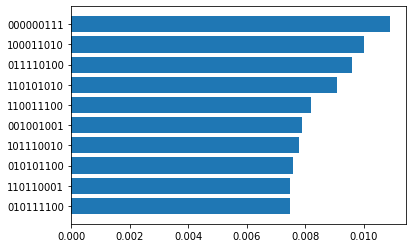

In [25]:
states_with_probs = []
for state in tsp_solver.sampling_results:
    states_with_probs.append([''.join(map(str,state)), tsp_solver.sampling_results[state]/10000])
states_with_probs = sorted(states_with_probs,key=lambda x: -x[1])
plots.plot_state_histogram(states_with_probs[:10][::-1])

Since it might be hard for you to decode the bitstrings, let's take a look at the human-readable representation.
The two might actually differ, since many bitstrings may have the same representation in a case of an invalid solution. That's why we call the distribution coming from tsp_solver a `naive_distribution`.

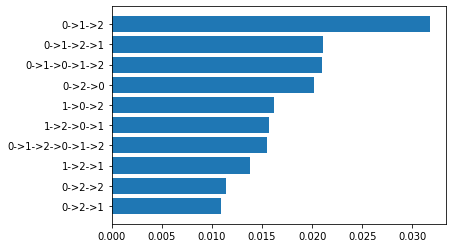

In [26]:
solutions_with_probs = []
for state in naive_distribution:
    solutions_with_probs.append(['->'.join(map(str,state)), naive_distribution[state]/10000])
solutions_with_probs = sorted(solutions_with_probs,key=lambda x: -x[1])

plots.plot_state_histogram(solutions_with_probs[:10][::-1])

As you can see, still many (if not most) of the solutions don't make sense. In the next part you will see how to further improve this algorithm.

## Summary and next steps

What we learned?
- how to solve problem with constraints using QAOA
- how to encode constraints and costs for TSP

What's next?
- improving the algorithm!